### Bitcoin Prices Scrapping

This notebook is for the 2nd part of Forcasting Course, in which Bitcoin Prices will be scrapped via "Coingecko" api.

In [65]:
# Imports

import requests
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [66]:
# CONFIGURATION (Universal)
TIME_SPAN_DAYS = 364       # Change this to 30, 100, 1000, etc.
INTERVAL = "1d"            # Options: '1d', '1wk', '1mo'

# ALLOWED INTERVALS and their meanings:
# '1d'   = daily
# '1wk'  = weekly
# '1mo'  = monthly
# Yahoo Finance does NOT support minutely/hourly for BTC

In [67]:
def fetch_btc_data_debug(days=TIME_SPAN_DAYS, interval=INTERVAL):
    end = datetime.today()
    start = end - pd.Timedelta(days=days)
    
    df = yf.download("BTC-USD", start=start, end=end, interval=interval)

    print("\n Raw Columns:", df.columns)
    print("\n Sample Data:")
    print(df.head(2))

    return df

In [68]:
raw_df = fetch_btc_data_debug()

[*********************100%***********************]  1 of 1 completed


 Raw Columns: MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

 Sample Data:
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2024-06-17  66490.296875  67188.320312  65094.964844  66636.515625   
2024-06-18  65140.746094  66556.703125  64066.957031  66490.976562   

Price            Volume  
Ticker          BTC-USD  
Date                     
2024-06-17  30006354476  
2024-06-18  39481285950  


In [69]:
def fetch_btc_data(days=TIME_SPAN_DAYS, interval=INTERVAL):
    """
    Fetch BTC-USD from Yahoo Finance with MultiIndex flattening.
    Returns: DataFrame with 'timestamp' and 'price'
    """
    end = datetime.today()
    start = end - pd.Timedelta(days=days)

    df = yf.download("BTC-USD", start=start, end=end, interval=interval)

    if df.empty:
        print(" No data returned.")
        return pd.DataFrame()

    #  Flatten MultiIndex (Price, Ticker) → "Close BTC-USD"
    df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    #  Reset index to access 'Date'
    df = df.reset_index()

    #  Rename columns
    if "Date" in df.columns and "Close BTC-USD" in df.columns:
        df = df.rename(columns={"Date": "timestamp", "Close BTC-USD": "price"})
    else:
        print(" Columns not found after flattening.")
        return pd.DataFrame()

    #  Clean up
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df = df.dropna(subset=["price", "timestamp"])

    print(f" Cleaned data shape: {df.shape} | Interval: {interval} | Days: {days}")
    return df

In [70]:
btc_df = fetch_btc_data()
btc_df.head()

[*********************100%***********************]  1 of 1 completed

 Cleaned data shape: (364, 6) | Interval: 1d | Days: 364


,timestamp,price,High BTC-USD,Low BTC-USD,Open BTC-USD,Volume BTC-USD
0,2024-06-17,66490.296875,67188.320312,65094.964844,66636.515625,30006354476
1,2024-06-18,65140.746094,66556.703125,64066.957031,66490.976562,39481285950
2,2024-06-19,64960.296875,65695.351562,64693.300781,65146.660156,21103423504
3,2024-06-20,64828.656250,66438.960938,64547.847656,64960.296875,25641109124
4,2024-06-21,64096.199219,65007.546875,63378.894531,64837.988281,26188171739


In [71]:
btc_df.describe()

,timestamp,price,High BTC-USD,Low BTC-USD,Open BTC-USD,Volume BTC-USD
count,364,364.000000,364.000000,364.000000,364.000000,3.640000e+02
mean,2024-12-15 12:03:57.362637056,82348.509744,83792.394156,80678.835777,82242.558454,4.276383e+10
min,2024-06-17 00:00:00,53948.753906,54838.144531,49121.238281,53949.085938,9.858199e+09
25%,2024-09-15 18:00:00,64163.942383,65004.765625,62867.602539,64160.741211,2.743734e+10
50%,2024-12-15 12:00:00,84799.988281,86450.242188,83619.207031,84622.660156,3.736139e+10
75%,2025-03-16 06:00:00,97318.021484,98814.845703,95717.320312,97232.742188,5.177986e+10
max,2025-06-16 00:00:00,111673.281250,111970.171875,109285.070312,111679.359375,1.492189e+11
std,NaN,17408.230840,17589.151063,17128.070869,17385.869868,2.344510e+10


In [72]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       364 non-null    datetime64[ns]
 1   price           364 non-null    float64       
 2   High BTC-USD    364 non-null    float64       
 3   Low BTC-USD     364 non-null    float64       
 4   Open BTC-USD    364 non-null    float64       
 5   Volume BTC-USD  364 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 17.2 KB


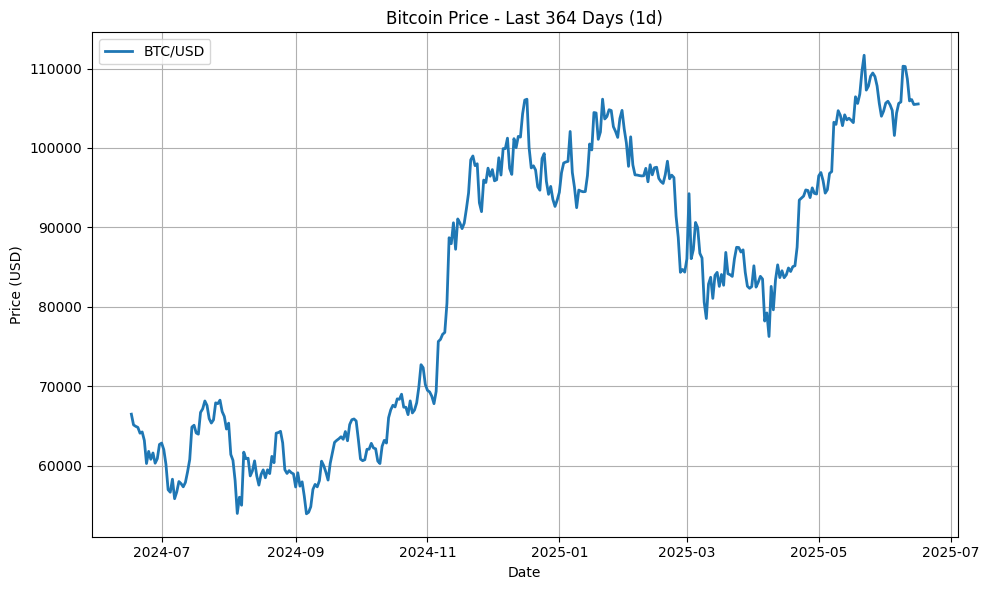

 Summary from 2024-06-17 to 2025-06-16:
- Min price:  $53,948.75
- Max price:  $111,673.28
- Mean price: $82,348.51


In [81]:
def plot_btc_price(df, title=None):
    """
    Plot BTC price over time and print summary stats.
    """
    if df.empty:
        print("No data to plot.")
        return

    if title is None:
        title = f"Bitcoin Price - Last {TIME_SPAN_DAYS} Days ({INTERVAL})"

    plt.figure(figsize=(10, 6))
    plt.plot(df["timestamp"], df["price"], label="BTC/USD", linewidth=2)
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Text summary
    print(f" Summary from {df['timestamp'].iloc[0].date()} to {df['timestamp'].iloc[-1].date()}:")
    print(f"- Min price:  ${df['price'].min():,.2f}")
    print(f"- Max price:  ${df['price'].max():,.2f}")
    print(f"- Mean price: ${df['price'].mean():,.2f}")


plot_btc_price(btc_df)



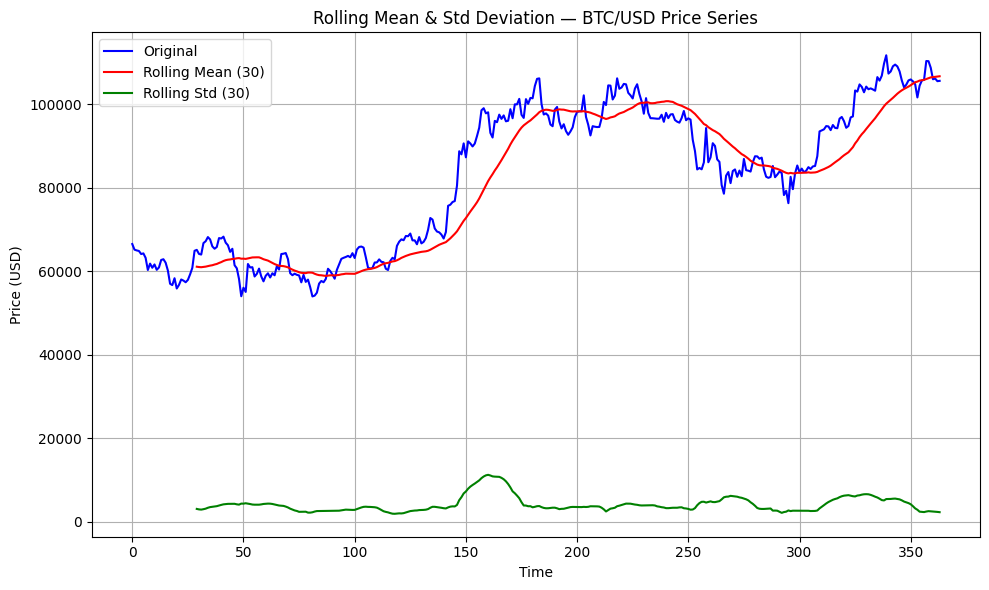


📉 ADF Test Results:
- ADF Statistic: -0.9516
- p-value: 0.7705
- Critical Value (1%): -3.4485
- Critical Value (5%): -2.8695
- Critical Value (10%): -2.5710
 Likely NON-STATIONARY (fail to reject H0)


In [80]:
def check_stationarity(series, window=30, title="BTC Price Series"):
    """
    Plot rolling stats and perform ADF test to check stationarity.
    """
    if series.isnull().all():
        print(" Series is empty or fully NaN.")
        return

    # Rolling mean & std
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()

    plt.figure(figsize=(10, 6))
    plt.plot(series, label="Original", color='blue')
    plt.plot(rolling_mean, label=f"Rolling Mean ({window})", color='red')
    plt.plot(rolling_std, label=f"Rolling Std ({window})", color='green')
    plt.title(f"Rolling Mean & Std Deviation — {title}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ADF Test
    print("\n📉 ADF Test Results:")
    result = adfuller(series.dropna())
    print(f"- ADF Statistic: {result[0]:.4f}")
    print(f"- p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"- Critical Value ({key}): {value:.4f}")

    if result[1] < 0.05:
        print(" Likely STATIONARY (reject H0)")
    else:
        print(" Likely NON-STATIONARY (fail to reject H0)")


check_stationarity(btc_df["price"], window=30, title="BTC/USD Price Series")


The rolling mean (red) clearly trends upward and then downward.

The rolling standard deviation (green) also fluctuates — especially during high volatility periods (mid-series).

This confirms changing mean and variance over time, which is the visual signature of non-stationarity.



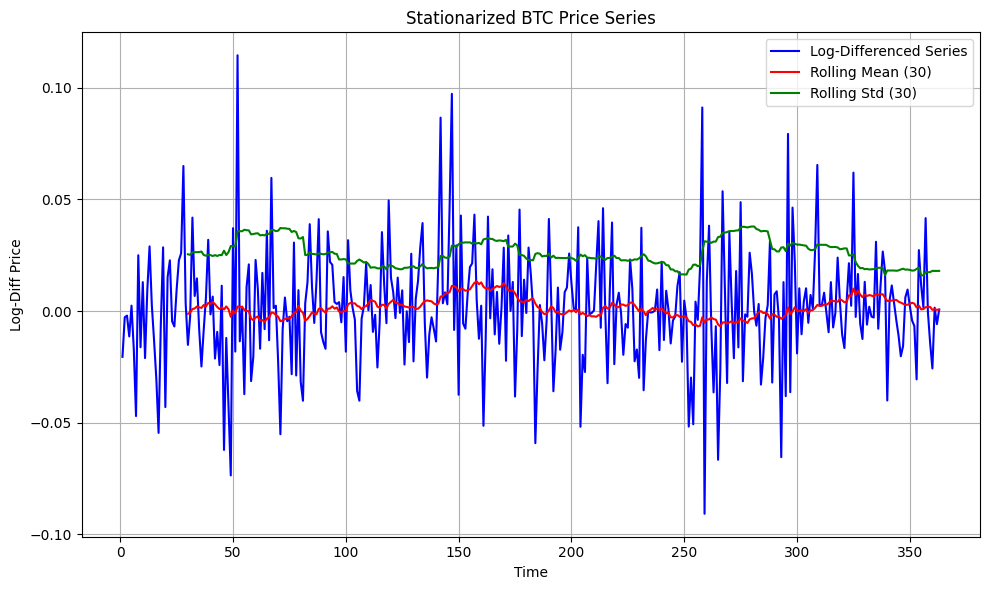

 ADF Test on Log-Differenced Series:
- ADF Statistic: -19.9619
- p-value: 0.0000
- Critical Value (1%): -3.4485
- Critical Value (5%): -2.8696
- Critical Value (10%): -2.5710
 Now STATIONARY (reject H0)


In [79]:
def make_stationary(df, column="price", window=30):
    """
    Apply log and differencing to make the series stationary.
    Then perform ADF test and plot rolling stats.
    """
    # Step 1: Log transform
    log_series = np.log(df[column])
    
    # Step 2: First-order differencing
    diff_series = log_series.diff().dropna()
    
    # Step 3: Rolling stats plot
    rolling_mean = diff_series.rolling(window).mean()
    rolling_std = diff_series.rolling(window).std()

    plt.figure(figsize=(10, 6))
    plt.plot(diff_series, label="Log-Differenced Series", color='blue')
    plt.plot(rolling_mean, label=f"Rolling Mean ({window})", color='red')
    plt.plot(rolling_std, label=f"Rolling Std ({window})", color='green')
    plt.title("Stationarized BTC Price Series")
    plt.xlabel("Time")
    plt.ylabel("Log-Diff Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Step 4: ADF Test
    print(" ADF Test on Log-Differenced Series:")
    result = adfuller(diff_series)
    print(f"- ADF Statistic: {result[0]:.4f}")
    print(f"- p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"- Critical Value ({key}): {value:.4f}")

    if result[1] < 0.05:
        print(" Now STATIONARY (reject H0)")
    else:
        print(" Still NON-STATIONARY")

    return diff_series



btc_stationary = make_stationary(btc_df, column="price", window=30)


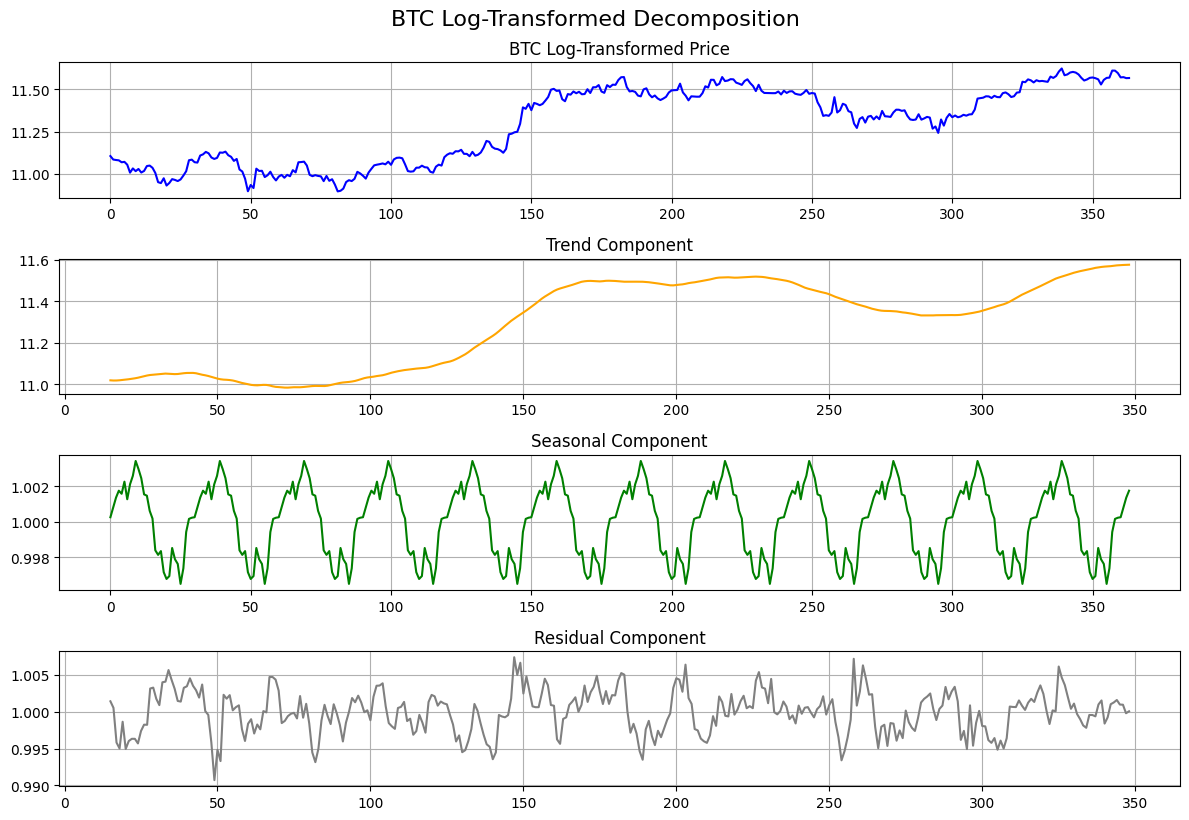

In [76]:
def decompose_series_clean(df, column="price", model="multiplicative", period=30):
    """
    Decompose log-transformed series and create a clean, annotated plot.
    """
    from statsmodels.tsa.seasonal import seasonal_decompose

    log_series = np.log(df[column])
    result = seasonal_decompose(log_series, model=model, period=period)

    # Extract components
    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid

    # Plot clean
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(log_series, label="Log Price", color="blue")
    plt.title("BTC Log-Transformed Price")
    plt.grid(True)

    plt.subplot(412)
    plt.plot(trend, label="Trend", color="orange")
    plt.title("Trend Component")
    plt.grid(True)

    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality", color="green")
    plt.title("Seasonal Component")
    plt.grid(True)

    plt.subplot(414)
    plt.plot(resid, label="Residuals", color="gray")
    plt.title("Residual Component")
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle("BTC Log-Transformed Decomposition", fontsize=16, y=1.02)
    plt.show()

    return result


decomposition_result = decompose_series_clean(btc_df, column="price", model="multiplicative", period=30)



 Trend: A smooth and gradual upward shift from around day 150 onward

 Seasonality: Regular cycles — consistent in amplitude and frequency

 Residual: Mostly noise — but with some mild structure, possibly still autocorrelated

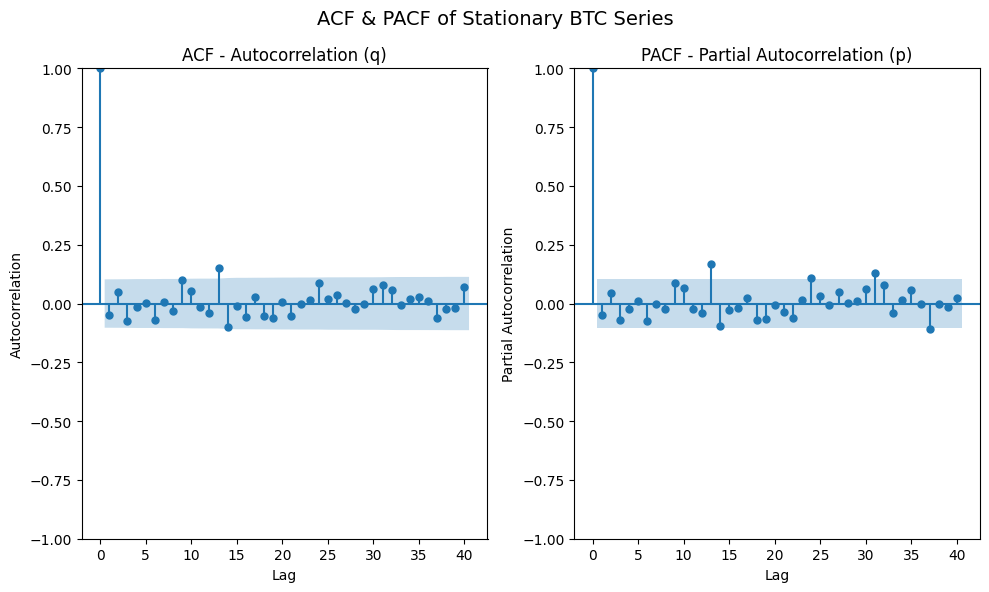

Interpretation Tips:
- ACF cuts off at lag X ⇒ q = X (Moving Average)
- PACF cuts off at lag Y ⇒ p = Y (Autoregressive)


In [ ]:
# Plot ACF and PACF using the stationary series
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# ACF Plot (for q)
plot_acf(btc_stationary.dropna(), ax=axes[0], lags=40)
axes[0].set_title("ACF - Autocorrelation (q)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(False)

# PACF Plot (for p)
plot_pacf(btc_stationary.dropna(), ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF - Partial Autocorrelation (p)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(False)

# Layout
plt.suptitle("ACF & PACF BTC Series", fontsize=14)
plt.tight_layout()
plt.show()

# Interpretation Hint
print("Interpretation Tips:")
print("- ACF cuts off at lag X ⇒ q = X (Moving Average)")
print("- PACF cuts off at lag Y ⇒ p = Y (Autoregressive)")